In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import yfinance as yf

from datetime import datetime
from invaas.poptions import poptions
from matplotlib.pyplot import figure
from pandarallel import pandarallel
from scipy import stats

pandarallel.initialize(nb_workers=12, progress_bar=True, verbose=2)

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

data_directory = "data/spy-options-data-2020-2022/"

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# raw_data_path = data_directory + "spy_2020_2022.csv"
# periods = 20

# df_formatted = pd.read_csv(raw_data_path, low_memory=False)

# columns = df_formatted.columns
# columns = [s.replace("[", "") for s in columns]
# columns = [s.replace("]", "") for s in columns]
# columns = [s.replace(" ", "") for s in columns]
# df_formatted.columns = columns

# date_columns = ["QUOTE_READTIME", "QUOTE_DATE", "EXPIRE_DATE"]
# numeric_cols = df_formatted.columns.to_list()
# numeric_cols.remove("QUOTE_READTIME")
# numeric_cols.remove("QUOTE_DATE")
# numeric_cols.remove("EXPIRE_DATE")

# df_formatted.drop(columns=date_columns, inplace=True)

# for i in numeric_cols:
#     df_formatted[i] = pd.to_numeric(df_formatted[i], errors="coerce")

# df_formatted.drop(columns=["C_SIZE", "P_SIZE"], inplace=True)
# df_formatted["EXPIRE_UNIX"] = pd.to_datetime(df_formatted.EXPIRE_UNIX, unit="s", utc=True)
# df_formatted["QUOTE_UNIXTIME"] = pd.to_datetime(df_formatted.QUOTE_UNIXTIME, unit="s", utc=True).apply(
#     lambda x: pd.Timestamp(x).round(freq="D")
# )
# df_formatted["OPTION_ID"] = (df_formatted["EXPIRE_UNIX"].astype(str) + df_formatted["STRIKE"].astype(str)).apply(
#     lambda x: hash(x)
# )
# df_formatted_total_options = (
#     df_formatted.groupby("OPTION_ID", as_index=False).size().rename(columns={"size": "total"})
# )
# df_formatted = df_formatted.loc[
#     df_formatted.OPTION_ID.isin(
#         df_formatted_total_options.loc[df_formatted_total_options.total > periods].OPTION_ID
#     )
# ]

# df_formatted.sort_values(by=["QUOTE_UNIXTIME", "EXPIRE_UNIX", "STRIKE"], inplace=True)
# df_formatted.reset_index(drop=True, inplace=True)
# df_formatted

In [ ]:
# def rolling_idmax(series, f):
#     # fist compute the index in the sliding window
#     ids = series.rolling(periods).apply(f)
#     # 0 <= ids <= n-1

#     # how many rows have past from the sliding window maximum?
#     ids = periods - 1 - ids
#     # 0 <= ids <= n-1

#     # subtract `ids` from the actual positions
#     ids = np.arange(len(series)) - ids
#     # 0 <= ids <= len(series)-1

#     # convert the positions stored in `ids` with the corrisponding dates (series.index)
#     ids.loc[~ids.isna()] = series.index[ids.dropna().astype(int)]
#     ids = ids.shift(periods-periods)

#     return ids

# def get_df_rolling_ask(df_formatted_group_by_option, ask_type, column):
#     f_type = np.argmax if ask_type == "MAX" else "MIN"
#     df_rolling_ask = pd.DataFrame(df_formatted_group_by_option.apply(rolling_idmax, f_type)).reset_index()
#     df_rolling_ask[column] = df_rolling_ask.groupby("level_0", as_index=False)[column].shift(periods=-periods)
#     max_column_rename = {}
#     max_column_rename[column] = f"{column}_{ask_type}_INDEX"
#     df_rolling_ask = df_rolling_ask.drop(columns="level_0").rename(columns=max_column_rename)
#     df_rolling_ask.set_index(keys="level_1", inplace=True)
#     max_column_rename[column] = f"{column}_{ask_type}"
#     return df_rolling_ask.merge(
#         df_formatted.rename(columns=max_column_rename)[[max_column_rename[column]]],
#         left_on=(f"{column}_{ask_type}_INDEX"),
#         right_index=True,
#         how="inner",
#     )

# # df_rolling_max_ask[column + "_INDEX"] = df_formatted.groupby("OPTION_ID", as_index=False)[column].apply(rolling_idmax, periods)
# # df_rolling_max_ask

# # periods = 20
# # results = df_formatted.groupby("OPTION_ID", as_index=False)["C_ASK"].apply(rolling_idmax, np.argmax)
# # results

In [ ]:
# def get_df_rolling_ask(df_formatted_group_by_option, ask_type):
#     f_type = np.argmax if ask_type == "MAX" else "MIN"
#     df_rolling_ask = pd.DataFrame(df_formatted_group_by_option.apply(rolling_idmax, f_type)).reset_index()
#     df_rolling_ask[column] = df_rolling_ask.groupby("level_0", as_index=False)[column].shift(periods=-periods)
#     max_column_rename = {}
#     max_column_rename[column] = f"{column}_{ask_type}_INDEX"
#     df_rolling_ask = df_rolling_ask.drop(columns="level_0").rename(columns=max_column_rename)
#     df_rolling_ask.set_index(keys="level_1", inplace=True)
#     max_column_rename[column] = f"{column}_{ask_type}"
#     return df_rolling_ask.merge(
#         df_formatted.rename(columns=max_column_rename)[[max_column_rename[column]]],
#         left_on=(f"{column}_{ask_type}_INDEX"),
#         right_index=True,
#         how="inner",
#     )


# for column in ["C_ASK", "P_ASK"]:
#     df_formatted_group_by_option = df_formatted.groupby("OPTION_ID", as_index=False)[column]
#     df_rolling_max_ask = get_df_rolling_ask(df_formatted_group_by_option, "MAX")
#     # df_rolling_min_ask = get_df_rolling_ask(df_formatted_group_by_option, "MIN")

#     break

#     # max_ask_column = f"MAX_{column}_{periods}"
#     # min_ask_column = f"MIN_{column}_{periods}"
#     # max_column_rename = {}
#     # min_column_rename = {}
#     # max_column_rename[column] = max_ask_column
#     # min_column_rename[column] = min_ask_column
#     # df_formatted.drop(columns=[max_ask_column, min_ask_column], errors="ignore", inplace=True)
#     # df_rolling_max_ask = (
#     #     df_formatted.groupby("OPTION_ID", as_index=False)[column]
#     #     .rolling(window=periods, min_periods=1)
#     #     .max()
#     #     .rename(columns=max_column_rename)
#     #     .drop(columns=["OPTION_ID"])
#     #     .join(df_formatted)[["OPTION_ID", max_ask_column]]
#     #     .groupby("OPTION_ID", as_index=False)
#     #     .shift(periods=-periods)
#     #     .join(df_formatted)[["OPTION_ID", max_ask_column]]
#     #     # .drop(columns=["OPTION_ID"])
#     # )
#     # df_rolling_min_ask = (
#     #     df_formatted.groupby("OPTION_ID", as_index=False)[column]
#     #     .rolling(window=periods, min_periods=1)
#     #     .min()
#     #     .rename(columns=min_column_rename)
#     #     .drop(columns=["OPTION_ID"])
#     #     .join(df_formatted)[["OPTION_ID", min_ask_column]]
#     #     .groupby("OPTION_ID", as_index=False)
#     #     .shift(periods=-periods)
#     #     .join(df_formatted)[["OPTION_ID", min_ask_column]]
#     #     .drop(columns=["OPTION_ID"])
#     # )
#     # df_formatted = df_formatted.join(df_rolling_max_ask)
#     # df_formatted = df_formatted.join(df_rolling_min_ask)

# df_rolling_max_ask

In [ ]:
# df_temp = df_formatted.join(df_rolling_max_ask)
# # df_temp = pd.DataFrame(results).reset_index()
# # df_temp["C_ASK"] = df_temp.groupby("level_0", as_index=False)["C_ASK"].shift(periods=-periods)
# # df_temp = df_temp.drop(columns="level_0").rename(columns={"C_ASK": "C_ASK_MAX_INDEX"})
# # df_temp.set_index(keys="level_1", inplace=True)
# # df_temp = (
# #     df_formatted.loc[
# #         df_formatted.OPTION_ID.isin(df_formatted_total_options.loc[df_formatted_total_options.total > 40].OPTION_ID)
# #     ][["OPTION_ID", "QUOTE_UNIXTIME", "EXPIRE_UNIX", "C_ASK"]]
# #     .join(df_temp)
# #     .merge(
# #         df_formatted.rename(columns={"C_ASK": "C_ASK_MAX"})[["C_ASK_MAX"]],
# #         left_on="C_ASK_MAX_INDEX",
# #         right_index=True,
# #         how="inner",
# #     )
# # )
# df_temp.loc[df_temp.OPTION_ID == -353919756800475513][["OPTION_ID", "QUOTE_UNIXTIME", "EXPIRE_UNIX", "C_ASK", "C_ASK_MAX_INDEX", "C_ASK_MAX"]]
# # # df_temp

In [2]:
# periods = 30  # BEST RESULT
# fear_greed_window = 20  # BEST RESULT

periods = 20
fear_greed_window = 10

refresh_formatted_data = False
refresh_processed_data = False

raw_data_path = data_directory + "spy_2020_2022.csv"
formatted_data_path = data_directory + f"spy_2020_2022_formatted_{periods}_{fear_greed_window}.csv"
processed_data_path = data_directory + f"spy_2020_2022_processed_{periods}_{fear_greed_window}.csv"


def rolling_idmax(series, f):
    # fist compute the index in the sliding window
    ids = series.rolling(periods).apply(f)
    # 0 <= ids <= n-1

    # how many rows have past from the sliding window maximum?
    ids = periods - 1 - ids
    # 0 <= ids <= n-1

    # subtract `ids` from the actual positions
    ids = np.arange(len(series)) - ids
    # 0 <= ids <= len(series)-1

    # convert the positions stored in `ids` with the corrisponding dates (series.index)
    ids.loc[~ids.isna()] = series.index[ids.dropna().astype(int)]
    ids = ids.shift(periods - periods)

    return ids


def get_df_rolling_ask(df_formatted_group_by_option, column, ask_type):
    f_type = np.argmax if ask_type == "MAX" else np.argmin
    df_rolling_ask = pd.DataFrame(df_formatted_group_by_option.apply(rolling_idmax, f_type)).reset_index()
    df_rolling_ask[column] = df_rolling_ask.groupby("level_0", as_index=False)[column].shift(periods=-periods)
    max_column_name = f"{ask_type}_{column}_{periods}"
    max_column_rename = {}
    max_column_rename[column] = f"{max_column_name}_INDEX"
    df_rolling_ask = df_rolling_ask.drop(columns="level_0").rename(columns=max_column_rename)
    df_rolling_ask.set_index(keys="level_1", inplace=True)
    max_column_rename[column] = max_column_name
    return df_rolling_ask.merge(
        df_formatted.rename(columns=max_column_rename)[[max_column_rename[column]]],
        left_on=(f"{max_column_name}_INDEX"),
        right_index=True,
        how="inner",
    )


if not refresh_processed_data and os.path.isfile(processed_data_path):
    df_options = pd.read_csv(processed_data_path, low_memory=False)
else:
    if not refresh_formatted_data and os.path.isfile(formatted_data_path):
        df_formatted = pd.read_csv(formatted_data_path, low_memory=False)
    else:
        df_formatted = pd.read_csv(raw_data_path, low_memory=False)

        columns = df_formatted.columns
        columns = [s.replace("[", "") for s in columns]
        columns = [s.replace("]", "") for s in columns]
        columns = [s.replace(" ", "") for s in columns]
        df_formatted.columns = columns

        date_columns = ["QUOTE_READTIME", "QUOTE_DATE", "EXPIRE_DATE"]
        numeric_cols = df_formatted.columns.to_list()
        numeric_cols.remove("QUOTE_READTIME")
        numeric_cols.remove("QUOTE_DATE")
        numeric_cols.remove("EXPIRE_DATE")

        df_formatted.drop(columns=date_columns, inplace=True)

        for i in numeric_cols:
            df_formatted[i] = pd.to_numeric(df_formatted[i], errors="coerce")

        df_formatted.drop(columns=["C_SIZE", "P_SIZE"], inplace=True)
        df_formatted["EXPIRE_UNIX"] = pd.to_datetime(df_formatted.EXPIRE_UNIX, unit="s", utc=True)
        df_formatted["OPTION_ID"] = (
            df_formatted["EXPIRE_UNIX"].astype(str) + df_formatted["STRIKE"].astype(str)
        ).apply(lambda x: hash(x))
        df_formatted_total_options = (
            df_formatted.groupby("OPTION_ID", as_index=False).size().rename(columns={"size": "total"})
        )
        df_formatted = df_formatted.loc[
            df_formatted.OPTION_ID.isin(
                df_formatted_total_options.loc[df_formatted_total_options.total > periods].OPTION_ID
            )
        ]
        df_formatted["QUOTE_UNIXTIME"] = pd.to_datetime(df_formatted.QUOTE_UNIXTIME, unit="s", utc=True).apply(
            lambda x: pd.Timestamp(x).round(freq="D")
        )
        df_formatted.sort_values(by=["QUOTE_UNIXTIME", "EXPIRE_UNIX", "STRIKE"], inplace=True)
        df_formatted.reset_index(drop=True, inplace=True)

        for column in ["C_ASK", "P_ASK"]:
            df_formatted_group_by_option = df_formatted.groupby("OPTION_ID", as_index=False)[column]
            df_rolling_max_ask = get_df_rolling_ask(
                df_formatted_group_by_option=df_formatted_group_by_option,
                column=column,
                ask_type="MAX",
            )
            df_rolling_min_ask = get_df_rolling_ask(
                df_formatted_group_by_option=df_formatted_group_by_option,
                column=column,
                ask_type="MIN",
            )
            # max_ask_column = f"MAX_{column}_{periods}"
            # min_ask_column = f"MIN_{column}_{periods}"
            # max_column_rename = {}
            # min_column_rename = {}
            # max_column_rename[column] = max_ask_column
            # min_column_rename[column] = min_ask_column
            # df_formatted.drop(columns=[max_ask_column, min_ask_column], errors="ignore", inplace=True)
            # df_rolling_max_ask = (
            #     df_formatted.groupby("OPTION_ID", as_index=False)[column]
            #     .rolling(window=periods, min_periods=1)
            #     .max()
            #     .rename(columns=max_column_rename)
            #     .drop(columns=["OPTION_ID"])
            #     .join(df_formatted)[["OPTION_ID", max_ask_column]]
            #     .groupby("OPTION_ID", as_index=False)
            #     .shift(periods=-periods)
            #     .join(df_formatted)[["OPTION_ID", max_ask_column]]
            #     .drop(columns=["OPTION_ID"])
            # )
            # df_rolling_min_ask = (
            #     df_formatted.groupby("OPTION_ID", as_index=False)[column]
            #     .rolling(window=periods, min_periods=1)
            #     .min()
            #     .rename(columns=min_column_rename)
            #     .drop(columns=["OPTION_ID"])
            #     .join(df_formatted)[["OPTION_ID", min_ask_column]]
            #     .groupby("OPTION_ID", as_index=False)
            #     .shift(periods=-periods)
            #     .join(df_formatted)[["OPTION_ID", min_ask_column]]
            #     .drop(columns=["OPTION_ID"])
            # )
            df_formatted = df_formatted.join(df_rolling_max_ask)
            df_formatted = df_formatted.join(df_rolling_min_ask)

        with open("data/cnn_fear_greed_index_data.json") as f:
            cnn_fear_greed_index_data = json.load(f)

        df_fear_greed_index = pd.DataFrame(
            data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"]
        )
        df_fear_greed_index["QUOTE_UNIXTIME"] = pd.DatetimeIndex(
            [pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]
        )
        df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
        df_fear_greed_index["fear_greed_index"] = df_fear_greed_index.fear_greed_index.astype(float).round().shift()
        df_fear_greed_index[f"fear_greed_index_max_{fear_greed_window}"] = df_fear_greed_index.fear_greed_index.rolling(
            window=fear_greed_window, min_periods=fear_greed_window
        ).max()
        df_fear_greed_index[f"fear_greed_index_min_{fear_greed_window}"] = df_fear_greed_index.fear_greed_index.rolling(
            window=fear_greed_window, min_periods=fear_greed_window
        ).min()
        df_formatted = df_formatted.merge(
            df_fear_greed_index[
                [
                    "QUOTE_UNIXTIME",
                    "fear_greed_index",
                    f"fear_greed_index_max_{fear_greed_window}",
                    f"fear_greed_index_min_{fear_greed_window}",
                ]
            ],
            on="QUOTE_UNIXTIME",
            how="left",
        )

        # df_irx_history = yf.Ticker("^IRX").history(interval="1d", period="5y")
        # df_irx_history.columns = [f"IRX_{x}" for x in map(str.lower, df_irx_history.columns)]
        # df_irx_history["QUOTE_UNIXTIME"] = [
        #     pd.to_datetime(x, utc=True).round(freq="D") for x in df_irx_history.index.values
        # ]
        # df_formatted = df_formatted.merge(
        #     df_irx_history[["QUOTE_UNIXTIME", "IRX_close"]], on="QUOTE_UNIXTIME", how="inner"
        # )

        # df_formatted.reset_index(inplace=True, drop=True)
        df_formatted.to_csv(formatted_data_path, index=False)

    def get_options_data(row):
        return [
            {
                # "contract_id": row.OPTION_ID,
                "option_id": hash("call" + str(row.OPTION_ID)),
                "option_type": "call",
                "quote_unixtime": row.QUOTE_UNIXTIME,
                "expire_unixtime": row.EXPIRE_UNIX,
                "days_to_expire": row.DTE,
                "underlying_last": row.UNDERLYING_LAST,
                "strike": row.STRIKE,
                "strike_distance": row.STRIKE_DISTANCE,
                "strike_distance_pct": row.STRIKE_DISTANCE_PCT,
                "delta": row.C_DELTA,
                "gamma": row.C_GAMMA,
                "vega": row.C_VEGA,
                "theta": row.C_THETA,
                "rho": row.C_RHO,
                "iv": row.C_IV,
                "volume": row.C_VOLUME,
                "last": row.C_LAST,
                "bid": row.C_BID,
                "ask": row.C_ASK,
                "max_ask": row[f"MAX_C_ASK_{periods}"],
                "max_ask_index": row[f"MAX_C_ASK_{periods}_INDEX"],
                "min_ask": row[f"MIN_C_ASK_{periods}"],
                "min_ask_index": row[f"MIN_C_ASK_{periods}_INDEX"],
                # "irx": row.IRX_close,
                "fear_greed_index": row.fear_greed_index,
                "fear_greed_index_max": row[f"fear_greed_index_max_{fear_greed_window}"],
                "fear_greed_index_min": row[f"fear_greed_index_min_{fear_greed_window}"],
            },
            {
                # "contract_id": row.OPTION_ID,
                "option_id": hash("put" + str(row.OPTION_ID)),
                "option_type": "put",
                "quote_unixtime": row.QUOTE_UNIXTIME,
                "expire_unixtime": row.EXPIRE_UNIX,
                "days_to_expire": row.DTE,
                "underlying_last": row.UNDERLYING_LAST,
                "strike": row.STRIKE,
                "strike_distance": row.STRIKE_DISTANCE,
                "strike_distance_pct": row.STRIKE_DISTANCE_PCT,
                "delta": row.P_DELTA,
                "gamma": row.P_GAMMA,
                "vega": row.P_VEGA,
                "theta": row.P_THETA,
                "rho": row.P_RHO,
                "iv": row.P_IV,
                "volume": row.P_VOLUME,
                "last": row.P_LAST,
                "bid": row.P_BID,
                "ask": row.P_ASK,
                "max_ask": row[f"MAX_P_ASK_{periods}"],
                "max_ask_index": row[f"MAX_P_ASK_{periods}_INDEX"],
                "min_ask": row[f"MIN_P_ASK_{periods}"],
                "min_ask_index": row[f"MIN_P_ASK_{periods}_INDEX"],
                # "irx": row.IRX_close,
                "fear_greed_index": row.fear_greed_index,
                "fear_greed_index_max": row[f"fear_greed_index_max_{fear_greed_window}"],
                "fear_greed_index_min": row[f"fear_greed_index_min_{fear_greed_window}"],
            },
        ]

    def flatten(xss):
        return [x for xs in xss for x in xs]

    options_data = flatten(df_formatted[: len(df_formatted)].parallel_apply(get_options_data, axis=1))
    df_options = pd.DataFrame(data=options_data)
    df_options.to_csv(processed_data_path, index=False)

df_options

,contact_id,option_id,option_type,quote_unixtime,expire_unixtime,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,max_ask_index,min_ask,min_ask_index,fear_greed_index,fear_greed_index_max,fear_greed_index_min
0,-2866931652584540975,5424209559497465478,call,2020-01-03 00:00:00+00:00,2020-01-31 21:00:00+00:00,29.00,324.87,255.0,69.9,0.215,0.99254,0.00067,0.01952,-0.01130,0.20686,0.35727,1.0,66.82,69.87,70.05,77.27,32143.0,67.22,64071.0,NaN,NaN,NaN
1,-2866931652584540975,-6198196423869331732,put,2020-01-03 00:00:00+00:00,2020-01-31 21:00:00+00:00,29.00,324.87,255.0,69.9,0.215,-0.00379,0.00033,0.01031,-0.00484,-0.00110,0.32142,16.0,0.03,0.03,0.04,0.04,2677.0,0.01,32143.0,NaN,NaN,NaN
2,49179386935262434,8674857863534908196,call,2020-01-03 00:00:00+00:00,2020-01-31 21:00:00+00:00,29.00,324.87,260.0,64.9,0.200,0.98654,0.00101,0.03238,-0.01868,0.20993,0.36143,10.0,60.50,64.94,65.13,72.30,32144.0,62.23,64072.0,NaN,NaN,NaN
3,49179386935262434,8770581224616408606,put,2020-01-03 00:00:00+00:00,2020-01-31 21:00:00+00:00,29.00,324.87,260.0,64.9,0.200,-0.00465,0.00052,0.01345,-0.00650,-0.00176,0.30648,3.0,0.04,0.04,0.05,0.05,2678.0,0.01,16557.0,NaN,NaN,NaN
4,2084709766309251964,853379470667210519,call,2020-01-03 00:00:00+00:00,2020-01-31 21:00:00+00:00,29.00,324.87,265.0,59.9,0.184,0.97933,0.00146,0.04691,-0.02728,0.21135,0.35875,NaN,0.00,60.01,60.26,67.28,32145.0,57.21,64073.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6705099,6146676970058885958,-5744676056438529359,put,2022-12-31 00:00:00+00:00,2025-03-21 20:00:00+00:00,811.96,382.44,590.0,207.6,0.543,-1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,0.00,202.75,210.00,NaN,NaN,NaN,NaN,37.0,40.0,36.0
6705100,8041341103049735812,-3976181627763305135,call,2022-12-31 00:00:00+00:00,2025-03-21 20:00:00+00:00,811.96,382.44,595.0,212.6,0.556,0.09466,0.00169,0.96298,-0.01292,0.72396,0.17885,NaN,0.00,1.73,6.50,NaN,NaN,NaN,NaN,37.0,40.0,36.0
6705101,8041341103049735812,3136102394626564851,put,2022-12-31 00:00:00+00:00,2025-03-21 20:00:00+00:00,811.96,382.44,595.0,212.6,0.556,-0.90719,0.00326,0.61124,-0.00505,-1.24251,0.28500,NaN,0.00,207.82,217.78,NaN,NaN,NaN,NaN,37.0,40.0,36.0
6705102,-7725357269324500604,-5537968184120190184,call,2022-12-31 00:00:00+00:00,2025-03-21 20:00:00+00:00,811.96,382.44,600.0,217.6,0.569,0.09424,0.00161,0.95513,-0.01327,0.71483,0.18161,0.0,4.60,2.25,6.00,NaN,NaN,NaN,NaN,37.0,40.0,36.0


<Axes: xlabel='quote_unixtime'>

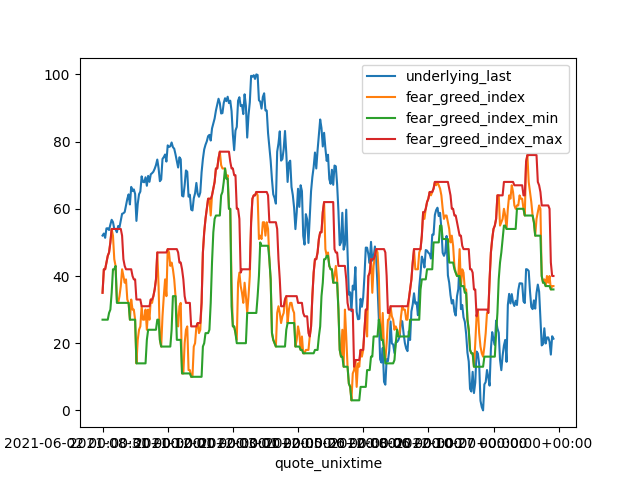

In [3]:
plot_columns = ["underlying_last", "fear_greed_index", "fear_greed_index_min", "fear_greed_index_max"]
df_plot = df_options[["quote_unixtime"] + plot_columns].dropna().drop_duplicates()
df_plot["underlying_last"] = (
    (df_plot.underlying_last - df_plot.underlying_last.min())
    / (df_plot.underlying_last.max() - df_plot.underlying_last.min())
    * 100
)
df_plot.plot(x="quote_unixtime", y=plot_columns)

In [ ]:
# min_dte = periods
# # min_dte = 20
# max_dte = 40
# # min_dte = 30  # BEST RESULT
# # max_dte = 90  # BEST RESULT
# max_ask = 10
# # min_ask = max_ask / 10
# min_ask = 0.1
# min_volume = 1
# max_strike_distance_pct = 0.05
# target_profit = 1.2

# df_options_filtered = df_options.loc[
#     (df_options.fear_greed_index_max.notnull())
#     & (df_options.bid > 0)
#     & (df_options.ask > 0)
#     & (df_options.ask < max_ask)
#     & (df_options.ask > min_ask)
#     & (df_options.volume > min_volume)
#     & (df_options.strike_distance_pct < max_strike_distance_pct)
#     & (df_options.days_to_expire > min_dte)
#     & (df_options.days_to_expire < max_dte)
# ][
#     [
#         "option_id",
#         "option_type",
#         "underlying_last",
#         "strike",
#         "expire_unixtime",
#         "ask",
#         "days_to_expire",
#         "iv",
#         # "irx",
#         "max_ask",
#         "max_ask_index",
#         "min_ask",
#         "min_ask_index",
#         "fear_greed_index",
#         "fear_greed_index_min",
#         "fear_greed_index_max",
#     ]
# ].drop_duplicates()


# # def get_pop(row):
# #     # if (row.underlying_last * row.strike * row.ask * row.days_to_expire * row.iv) == 0:
# #     #     return 0

# #     pop_func = poptions.longCall if row.option_type == "call" else poptions.longPut
# #     pop_data = pop_func(
# #         underlying=row.underlying_last,
# #         long_strike=row.strike,
# #         long_price=row.ask,
# #         days_to_expiration=int(row.days_to_expire),
# #         closing_days_array=[(periods if periods < row.days_to_expire else int(row.days_to_expire))],
# #         sigma=row.iv * 100,
# #         rate=0,
# #         # rate=row.irx,
# #         trials=100,
# #         multiple_array=[target_profit],
# #     )
# #     # print(pop_data)
# #     return {"pop": pop_data["pop"][0], "pop_error": pop_data["pop_error"][0]}


# # # pops = []
# # # num = 0
# # # total = len(df_options)

# # # for index, row in df_options.iterrows():
# # #     num += 1
# # #     print(f"{num}/{total} -- ({num/total*100:.2f}%)", end="\r")
# # #     pops.append(get_pop(row))

# # # df_options_filtered["pop"] = pops

# # pops = df_options_filtered.parallel_apply(get_pop, axis=1)
# # df_options_filtered["probability_of_profit"] = [x["pop"] for x in pops]
# # df_options_filtered["probability_of_profit_error"] = [x["pop_error"] for x in pops]

# df_options_filtered.dropna(subset=["max_ask", "min_ask"], inplace=True)
# df_options_filtered

In [ ]:
# df_options_filtered.describe().astype(str)
# df_options_filtered.loc[df_options_filtered.probability_of_profit > 0]
# df_options_filtered.loc[df_options_filtered.probability_of_profit > 0].groupby("option_type", as_index=False).size()

# processed_filtered_data_path = data_directory + "spy_2020_2022_processed_filtered.csv"
# df_options_filtered.to_csv(processed_filtered_data_path, index=False)
# df_options_filtered = pd.read_csv(processed_filtered_data_path, low_memory=False)

In [ ]:
# df_options.drop(columns=["probability_of_profit", "probability_of_profit_error"], errors="ignore", inplace=True)
# df_options = df_options.join(df_options_filtered[["probability_of_profit", "probability_of_profit_error"]], how="left")
# df_options

In [4]:
df_options["max_ask_pct"] = (df_options.max_ask - df_options.ask) / df_options.ask
df_options["min_ask_pct"] = (df_options.min_ask - df_options.ask) / df_options.ask
df_options["max_before_min"] = df_options.max_ask_index < df_options.min_ask_index
df_options["in_the_money"] = ((df_options.option_type == "call") & (df_options.strike < df_options.underlying_last)) | (
    (df_options.option_type == "put") & (df_options.strike > df_options.underlying_last)
)

df_options.describe(include="all").astype(str)

/home/vscode/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/vscode/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,contact_id,option_id,option_type,quote_unixtime,expire_unixtime,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,max_ask_index,min_ask,min_ask_index,fear_greed_index,fear_greed_index_max,fear_greed_index_min,max_ask_pct,min_ask_pct,max_before_min,in_the_money
count,6705104.0,6705104.0,6705104,6705104,6705104,6705104.0,6705104.0,6705104.0,6705104.0,6705104.0,6704718.0,6704718.0,6704718.0,6704718.0,6704718.0,6379498.0,5430040.0,6703192.0,6703192.0,6703192.0,4603046.0,4603046.0,4603046.0,4603046.0,3104976.0,3025000.0,3025000.0,4601392.0,4600293.0,6705104,6705104
unique,nan,nan,2,758,475,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,2
top,nan,nan,call,2021-11-06 00:00:00+00:00,2021-12-17 21:00:00+00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,False
freq,nan,nan,3352552,10982,222246,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4061532,3352734
mean,3.6020887864507424e+16,1759415045704861.5,nan,nan,nan,165.569171150813,387.19143309932264,367.258820146563,71.87527549162552,0.18726444332556216,0.05852685361114359,-5.539010259172714,-4.591413383244466,-0.06525248893689488,-0.13273299260908508,0.3319192409606522,248.14380299224314,24.879528029332892,41.13185712567984,42.06987972297378,55.66110866804285,1664409.2482395354,41.49832659069676,1675577.0560013957,39.144283884964004,47.99188165289256,29.14705785123967,inf,inf,nan,nan
std,5.337257368243994e+18,5.299126422654202e+18,nan,nan,nan,205.26504897883348,56.119759445888285,110.414241734368,69.74638091674225,0.17758214171887793,0.6172408840004929,7265.928700629256,65.35914030587458,0.33726956602471037,4.943414620970326,0.3911653863338513,2996.713572218119,44.36007231067608,58.043199584864254,58.7510679326706,66.75857405183275,950136.5934682728,59.4009320672186,951772.7909329917,16.75612826873928,15.416249667639761,15.545756987865342,nan,nan,nan,nan
min,-9.223157630760117e+18,-9.223329650307247e+18,nan,nan,nan,0.0,222.21,5.0,0.0,0.0,-1.0,-14950363.96601,-2815.39969,-45.23137,-2878.27141,-0.0005,0.0,0.0,0.0,0.0,0.01,2677.0,0.0,2802.0,3.0,13.0,3.0,-0.9977678571428572,-1.0,nan,nan
25%,-4.5462354870665216e+18,-4.554155903650389e+18,nan,nan,nan,23.0,342.65,299.0,21.6,0.056,-0.34296,0.00062,0.07026,-0.07495,-0.17122,0.18541,0.0,0.06,1.88,2.08,6.61,847891.0,1.84,849088.0,26.0,34.0,18.0,0.03977548152648464,-0.5,nan,nan
50%,4.46228064312846e+16,7934888049263905.0,nan,nan,nan,80.0,393.97,368.0,49.8,0.131,0.0,0.00297,0.29822499999999996,-0.04169,0.0,0.25123,3.0,5.32,16.7,17.46,29.95,1655381.5,15.27,1654771.0,37.0,47.0,25.0,0.16300847224397788,-0.2234042553191489,nan,nan
75%,4.684384310178068e+18,4.5736842715487754e+18,nan,nan,nan,235.04,434.37,437.0,103.6,0.273,0.6565274999999999,0.00649,0.73064,-0.01626,0.17039,0.35641,30.0,29.33,55.64,57.21,80.73,2477500.0,56.48,2478174.0,53.0,62.0,40.0,0.423076923076923,-0.07272727272727272,nan,nan


In [52]:
with open("data/cnn_fear_greed_index_data.json") as f:
    cnn_fear_greed_index_data = json.load(f)

df_fear_greed_index = pd.DataFrame(data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"])
df_fear_greed_index["QUOTE_UNIXTIME"] = pd.DatetimeIndex(
    [pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]
)
df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
df_fear_greed_index["fear_greed_index"] = df_fear_greed_index.fear_greed_index.astype(float).round().shift()
df_fear_greed_index[f"fear_greed_index_max_{fear_greed_window}"] = df_fear_greed_index.fear_greed_index.rolling(
    window=fear_greed_window, min_periods=fear_greed_window
).max()
df_fear_greed_index[f"fear_greed_index_min_{fear_greed_window}"] = df_fear_greed_index.fear_greed_index.rolling(
    window=fear_greed_window, min_periods=fear_greed_window
).min()

###

df_fear_greed_index["fear_greed_index"] = df_fear_greed_index.fear_greed_index.ffill()
df_fear_greed_index.dropna(subset="fear_greed_index", inplace=True)
df_fear_greed_index["quote_unixtime_ordinal"] = pd.to_datetime(df_fear_greed_index.QUOTE_UNIXTIME).map(
    datetime.toordinal
)
df_fear_greed_index.sort_values(by="quote_unixtime_ordinal", ascending=True, inplace=True)

df_fear_greed_index

,x,fear_greed_index,QUOTE_UNIXTIME,fear_greed_index_max_10,fear_greed_index_min_10,quote_unixtime_ordinal
1,2021-05-18,36.0,2021-05-18 00:00:00+00:00,NaN,NaN,737928
2,2021-05-19,35.0,2021-05-19 00:00:00+00:00,NaN,NaN,737929
3,2021-05-20,32.0,2021-05-20 00:00:00+00:00,NaN,NaN,737930
4,2021-05-21,33.0,2021-05-21 00:00:00+00:00,NaN,NaN,737931
5,2021-05-24,30.0,2021-05-24 00:00:00+00:00,NaN,NaN,737934
...,...,...,...,...,...,...
769,2024-03-25,68.0,2024-03-25 00:00:00+00:00,75.0,65.0,738970
770,2024-03-26,69.0,2024-03-26 00:00:00+00:00,75.0,68.0,738971
771,2024-03-27,68.0,2024-03-27 00:00:00+00:00,75.0,68.0,738972
772,2024-03-28,71.0,2024-03-28 00:00:00+00:00,75.0,68.0,738973


In [54]:
stats.linregress(df_fear_greed_index.quote_unixtime_ordinal, df_fear_greed_index.fear_greed_index).slope

0.036147862090386944

In [17]:
# min_probability_of_profit = 0
# df_options["did_buy"] = (
#     # (df_options.probability_of_profit > min_probability_of_profit)
#     (df_options.fear_greed_index == df_options.fear_greed_index_max)
#     | (df_options.fear_greed_index == df_options.fear_greed_index_min)
#     # (
#     #     ((df_options.option_type == "call") & (df_options.fear_greed_index == df_options.fear_greed_index_max))
#     #     | ((df_options.option_type == "put") & (df_options.fear_greed_index == df_options.fear_greed_index_min))
#     # )
# )
# df_options["should_buy"] = df_options.max_ask > (df_options.ask * target_profit)
# df_options.groupby(["did_buy", "should_buy"], as_index=False).size()
# # df_options.loc[df_options.did_buy].groupby(["quote_unixtime", "did_buy", "should_buy"], as_index=False).size()

min_dte = periods
max_dte = 50
# min_dte = 30  # BEST RESULT
# max_dte = 90  # BEST RESULT
max_ask = 1
# min_ask = max_ask / 10
min_ask = 0.2
min_volume = 100
# max_strike_distance_pct = 0.1
min_strike_distance_pct = 0.1
target_profit = 1.2

df_options["should_buy"] = (
    df_options.max_before_min
    & (df_options.max_ask > (df_options.ask * target_profit))
    & (df_options.min_ask < (df_options.ask * (2 - target_profit)))
)
df_options_filtered = df_options.loc[
    # (df_options.fear_greed_index_max.notnull())
    (~df_options.in_the_money)
    & (df_options.bid > 0)
    & (df_options.ask > 0)
    # & (df_options.ask < max_ask)
    & (df_options.ask > min_ask)
    & (df_options.volume > min_volume)
    # & (df_options.strike_distance_pct < max_strike_distance_pct)
    & (df_options.strike_distance_pct > min_strike_distance_pct)
    & (df_options.days_to_expire > min_dte)
    & (df_options.days_to_expire < max_dte)
]

df_options_filtered.dropna(subset=["max_ask", "min_ask"], inplace=True)

min_fear_greed_index_threshold = 30
max_fear_greed_index_threshold = 70
max_diff = 0

df_options_filtered["did_buy"] = (
    (df_options_filtered.option_type == "call")
    & (
        # (df_options_filtered.fear_greed_index < min_fear_greed_index_threshold)
        # | (
        #     (df_options_filtered.fear_greed_index > 60)
        #     (df_options_filtered.fear_greed_index >= min_fear_greed_index_threshold)
        #     (df_options_filtered.fear_greed_index <= max_fear_greed_index_threshold)
        #     (
        (df_options_filtered.fear_greed_index >= (df_options_filtered.fear_greed_index_max - max_diff))
        # (df_options_filtered.fear_greed_index <= (df_options_filtered.fear_greed_index_min + max_diff))
        #     )
        # )
    )
) | (
    (df_options_filtered.option_type == "put")
    & (
        # (df_options_filtered.fear_greed_index > max_fear_greed_index_threshold)
        # | (
        #     (df_options_filtered.fear_greed_index >= min_fear_greed_index_threshold)
        #     & (df_options_filtered.fear_greed_index < 40)
        #     & (df_options_filtered.fear_greed_index <= max_fear_greed_index_threshold)
        #     (
        # (df_options_filtered.fear_greed_index >= (df_options_filtered.fear_greed_index_max - max_diff))
        (df_options_filtered.fear_greed_index <= (df_options_filtered.fear_greed_index_min + max_diff))
        #     )
        # )
    )
)

# df_options_filtered["did_buy"] = (
#     (df_options_filtered.fear_greed_index == df_options_filtered.fear_greed_index_min)
# ) | ((df_options_filtered.fear_greed_index == df_options_filtered.fear_greed_index_max))
# df_options_filtered["should_buy"] = df_options_filtered.max_ask >= (df_options_filtered.ask * 0.5)
# df_options_filtered["should_buy"] = df_options_filtered.max_ask_pct_diff > 0

total_gains = (
    df_options_filtered.loc[df_options_filtered.did_buy & df_options_filtered.should_buy].ask
    * (target_profit - 1)
    * 100
).sum()
# total_gains = (df_options_filtered.loc[df_options_filtered.did_buy & df_options_filtered.should_buy].ask * (0.5) * 100).sum()

# max_loss = -0.1
max_loss = -1 if (1 - target_profit) < -1 else (1 - target_profit)
total_losses = (
    df_options_filtered.loc[df_options_filtered.did_buy & (~df_options_filtered.should_buy)].ask * max_loss * 100
).sum()
print(f"Total gains: ${total_gains:.2f}")
print(f"Total losses: ${total_losses:.2f}")
print(f"Total profit: ${total_gains + total_losses:.2f}")
df_options_filtered_grouped_size = df_options_filtered.groupby(["did_buy", "should_buy"], as_index=False).size()
# df_options.loc[df_options.did_buy].groupby(["quote_unixtime", "did_buy", "should_buy"], as_index=False).size()

did_buy_and_should_buy = df_options_filtered_grouped_size.loc[
    df_options_filtered_grouped_size.did_buy & df_options_filtered_grouped_size.should_buy
].iloc[0]["size"]
did_buy_and_should_not_buy = df_options_filtered_grouped_size.loc[
    df_options_filtered_grouped_size.did_buy & ~df_options_filtered_grouped_size.should_buy
].iloc[0]["size"]
print(f"Accuracy: {did_buy_and_should_buy/(did_buy_and_should_buy+did_buy_and_should_not_buy)*100:.2f}%")

df_options_filtered_grouped_size

Total gains: $20272.40
Total losses: $-33247.20
Total profit: $-12974.80
Accuracy: 44.15%


/tmp/ipykernel_2145/3621254758.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered.dropna(subset=["max_ask", "min_ask"], inplace=True)
/tmp/ipykernel_2145/3621254758.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered["did_buy"] = (


,did_buy,should_buy,size
0,False,False,14814
1,False,True,10293
2,True,False,1088
3,True,True,860


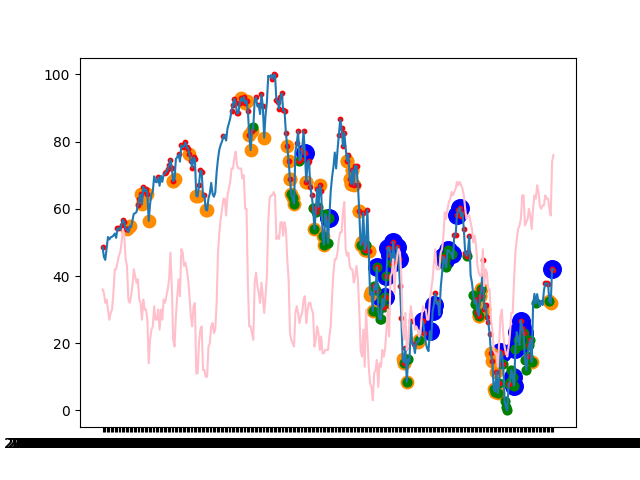

In [18]:
plot_columns = ["underlying_last", "fear_greed_index", "option_type", "did_buy", "should_buy"]
df_plot = df_options_filtered[["quote_unixtime"] + plot_columns].dropna().drop_duplicates()
df_plot["underlying_last"] = (
    (df_plot.underlying_last - df_plot.underlying_last.min())
    / (df_plot.underlying_last.max() - df_plot.underlying_last.min())
    * 100
)

fig = plt.figure()

plt.plot(df_plot.quote_unixtime, df_plot.underlying_last)
plt.plot(df_plot.quote_unixtime, df_plot.fear_greed_index, c="pink")
plt.scatter(
    df_plot.loc[df_plot.did_buy & (df_plot.option_type == "call")].quote_unixtime,
    df_plot.loc[df_plot.did_buy & (df_plot.option_type == "call")].underlying_last,
    s=160,
    c="blue",
)
plt.scatter(
    df_plot.loc[df_plot.did_buy & (df_plot.option_type == "put")].quote_unixtime,
    df_plot.loc[df_plot.did_buy & (df_plot.option_type == "put")].underlying_last,
    s=80,
    c="darkorange",
)
# plt.scatter(
#     df_plot.loc[df_plot.should_buy].quote_unixtime,
#     df_plot.loc[df_plot.should_buy].underlying_last,
#     s=60,
#     c="black",
# )
plt.scatter(
    df_plot.loc[df_plot.should_buy & (df_plot.option_type == "call")].quote_unixtime,
    df_plot.loc[df_plot.should_buy & (df_plot.option_type == "call")].underlying_last,
    s=40,
    c="green",
)
plt.scatter(
    df_plot.loc[df_plot.should_buy & (df_plot.option_type == "put")].quote_unixtime,
    df_plot.loc[df_plot.should_buy & (df_plot.option_type == "put")].underlying_last,
    s=10,
    c="red",
)

plt.show()

In [ ]:
# print(len(df_options_filtered.loc[(df_options_filtered.in_the_money) & (df_options_filtered.max_before_min)])/len(df_options_filtered.loc[df_options_filtered.in_the_money]))
# print(len(df_options_filtered.loc[(df_options_filtered.in_the_money) & (df_options_filtered.should_buy)])/len(df_options_filtered.loc[df_options_filtered.in_the_money]))

# print()

print(
    len(df_options_filtered.loc[(~df_options_filtered.in_the_money) & (df_options_filtered.max_before_min)])
    / len(df_options_filtered.loc[~df_options_filtered.in_the_money])
)
print(
    len(df_options_filtered.loc[(~df_options_filtered.in_the_money) & (df_options_filtered.should_buy)])
    / len(df_options_filtered.loc[~df_options_filtered.in_the_money])
)

df_options_filtered.loc[~df_options_filtered.in_the_money].describe(include="all").astype(str)

In [ ]:
money = 1000
start_money = money
# max_buy_price = max_ask * 100
# min_buy_price = min_ask * 100
contract_fee = 0
total_contracts = 1
# max_buy_amount = 5
max_buy_pct = 0.1
# max_owned_option_type = 100
min_gain_pct = target_profit - 1
max_loss_pct = -1 if (1 - target_profit) < -1 else (1 - target_profit)
# max_loss_pct = -0.1

first_quote_datetime = pd.to_datetime(
    df_options.loc[df_options.fear_greed_index_max.notnull()].quote_unixtime.values[0]
)
last_quote_datetime = pd.to_datetime(df_options.quote_unixtime.values[-1])
last_quote_date = last_quote_datetime.strftime(format="%Y-%m-%d")

# df_options_total = df_options.groupby("option_id", as_index=False).size().rename(columns={"size": "total"})
df_options_simulate = df_options.loc[
    # df_options.option_id.isin(df_options_total.loc[df_options_total.total > 30].option_id)
    (pd.to_datetime(df_options.quote_unixtime) >= first_quote_datetime)
    & df_options.option_id.isin(
        df_options[
            # df_options.probability_of_profit.notna()
            # & (df_options.probability_of_profit >= min_probability_of_profit)
            # df_options.fear_greed_index_max.notnull()
            ~df_options.in_the_money
            # & (
            #     (df_options.fear_greed_index == df_options.fear_greed_index_max)
            #     | (df_options.fear_greed_index == df_options.fear_greed_index_min)
            # )
            & (
                (
                    (df_options.option_type == "call")
                    & (
                        # (df_options.fear_greed_index < min_fear_greed_index_threshold)
                        # | (
                        #     (df_options.fear_greed_index > 60)
                        #     (df_options.fear_greed_index >= min_fear_greed_index_threshold)
                        (df_options.fear_greed_index <= max_fear_greed_index_threshold)
                        #     (df_options.fear_greed_index >= (df_options.fear_greed_index_max - max_diff))
                        #     (df_options.fear_greed_index <= (df_options.fear_greed_index_min + max_diff))
                        # )
                    )
                )
                | (
                    (df_options.option_type == "put")
                    & (
                        # (df_options.fear_greed_index > max_fear_greed_index_threshold)
                        # | (
                        (df_options.fear_greed_index >= min_fear_greed_index_threshold)
                        #     (df_options.fear_greed_index < 40)
                        #     (df_options.fear_greed_index <= max_fear_greed_index_threshold)
                        #     (df_options.fear_greed_index >= (df_options.fear_greed_index_max - max_diff))
                        #     (df_options.fear_greed_index <= (df_options.fear_greed_index_min + max_diff))
                        # )
                    )
                )
            )
            & (df_options.bid > 0)
            & (df_options.ask > 0)
            & (df_options.ask < max_ask)
            & (df_options.ask > min_ask)
            & (df_options.volume > min_volume)
            # & (df_options.strike_distance_pct < max_strike_distance_pct)
            & (df_options.strike_distance_pct > min_strike_distance_pct)
            & (df_options.days_to_expire > min_dte)
            & (df_options.days_to_expire < max_dte)
        ].option_id
    )
].sort_values(
    by=["quote_unixtime", "expire_unixtime", "ask"],
    ascending=[True, True, False],
)
# ].sort_values(
#     by=["quote_unixtime", "expire_unixtime", "days_to_expire", "strike_distance_pct"],
#     ascending=[True, True, True, True],
# )

owned_options = []
trade_data = []

num = 0
total = len(df_options_simulate)
total_days = (last_quote_datetime - first_quote_datetime).days

for index, row in df_options_simulate.iterrows():
    expire_date = pd.to_datetime(row.expire_unixtime).strftime(format="%Y-%m-%d")
    quote_date = pd.to_datetime(row.quote_unixtime).strftime(format="%Y-%m-%d")
    is_last_quote_date = quote_date == last_quote_date
    num += 1

    if num == total or num % 100 == 0:
        # days_remaining = (last_quote_datetime - pd.to_datetime(row.quote_unixtime)).days
        days_passed = (pd.to_datetime(row.quote_unixtime) - first_quote_datetime).days
        print(
            f"{num/total*100:.2f}% ({num}/{total}) -- {quote_date} ({days_passed}/{total_days}) -- {len(trade_data)} trades",
            end="\r",
        )

    good_call_buy = (row.option_type == "call") and (
        # (row.fear_greed_index < min_fear_greed_index_threshold)
        # or (
        #     (row.fear_greed_index > 60)
        #     (row.fear_greed_index >= min_fear_greed_index_threshold)
        (row.fear_greed_index <= max_fear_greed_index_threshold)
        #     (row.fear_greed_index >= (row.fear_greed_index_max - max_diff))
        #     (row.fear_greed_index <= (row.fear_greed_index_min + max_diff))
        # )
    )

    good_put_buy = (row.option_type == "put") and (
        # (row.fear_greed_index > max_fear_greed_index_threshold)
        # or (
        (row.fear_greed_index >= min_fear_greed_index_threshold)
        #     (row.fear_greed_index < 40)
        #     (row.fear_greed_index <= max_fear_greed_index_threshold)
        #     (row.fear_greed_index >= (row.fear_greed_index_max - max_diff))
        #     (row.fear_greed_index <= (row.fear_greed_index_min + max_diff))
        # )
    )

    # max_buy_price = 1000
    # max_buy_price = money
    # max_buy_price = money / max_buy_amount
    max_buy_price = max_ask * 100
    min_buy_price = min_ask * 100

    ask_price = 0 if np.isnan(row.ask) else row.ask * 100

    if (
        # not np.isnan(row.probability_of_profit)
        # and row.probability_of_profit > min_probability_of_profit
        # pd.notnull(row.fear_greed_index_max)
        ((row.option_type == "call" and good_call_buy) or (row.option_type == "put" and good_put_buy))
        and not row.in_the_money
        and not np.isnan(row.ask)
        and ask_price <= max_buy_price
        and ask_price >= min_buy_price
        and money >= ask_price
        and row.volume > min_volume
        # and row.strike_distance_pct < max_strike_distance_pct
        and row.strike_distance_pct > min_strike_distance_pct
        and row.days_to_expire > min_dte
        and row.days_to_expire < max_dte
        and row.days_to_expire < (last_quote_datetime - pd.to_datetime(row.quote_unixtime)).days
        and len([x for x in owned_options if x["option_id"] == row.option_id]) == 0
        # and len([x for x in owned_options if x["option_type"] == "call"]) < max_owned_option_type
        # and len([x for x in owned_options if x["option_type"] == "put"]) < max_owned_option_type
        # and (
        #     len([x for x in owned_options if x["purchase_date"] == quote_date and x["option_type"] == row.option_type])
        #     < max_buy_amount
        # )
        and ((ask_price / money) < max_buy_pct)
        and (sum([x["ask"] * 100 for x in owned_options if x["purchase_date"] == quote_date]) / money < max_buy_pct)
    ):
        money -= (ask_price + contract_fee) * total_contracts
        option_to_buy = row.to_dict()
        option_to_buy["purchase_date"] = quote_date
        owned_options.append(option_to_buy)
        print(
            f"{quote_date} ${money:.0f} {len(owned_options)} buy {row.option_type} {expire_date} {row.underlying_last} {row.strike} ${ask_price:.0f} {row.option_id}"
        )
        trade_data.append(
            {
                "id": row.option_id,
                "date": quote_date,
                "money": money,
                "side": "buy",
                "type": row.option_type,
                "price": ask_price,
                "options": len(owned_options),
                "days_to_expire": row.days_to_expire,
            }
        )

    owned_options_not_sold = []
    sold_options = 0

    for option in owned_options:
        is_option = option["option_id"] == row.option_id
        days_to_expire = (
            option["days_to_expire"]
            - (pd.to_datetime(row.quote_unixtime) - pd.to_datetime(option["quote_unixtime"])).days
        )
        purchase_price = option["ask"] * 100
        bid_price = 0 if not is_option or np.isnan(row.bid) else row.bid * 100
        pct_diff = (bid_price - purchase_price) / purchase_price

        if (
            is_last_quote_date
            or days_to_expire <= 1
            # or (is_option and (pct_diff > min_gain_pct or pct_diff < max_loss_pct))
            or (
                is_option
                and not np.isnan(row.bid)
                and (pct_diff >= min_gain_pct or pct_diff <= max_loss_pct)
                # and (
                #     (option["option_type"] == "call" and not good_call_buy)
                #     or (option["option_type"] == "put" and not good_put_buy)
                # )
            )
        ):
            sold_options += 1
            money += (bid_price - contract_fee) * total_contracts
            print(
                f"{quote_date} ${money:.0f} {len(owned_options)-sold_options} sell {option['option_type']} {expire_date} {option['underlying_last']} {option['strike']} ${bid_price:.0f} {option['option_id']} {days_to_expire}"
            )
            trade_data.append(
                {
                    "id": option["option_id"],
                    "date": quote_date,
                    "money": money,
                    "side": "sell",
                    "type": option["option_type"],
                    "price": bid_price,
                    "options": len(owned_options) - sold_options,
                    "days_to_expire": option["days_to_expire"],
                }
            )
        else:
            owned_options_not_sold.append(option)

    owned_options = owned_options_not_sold

print()
print(f"Start money: ${start_money:.2f}")
print(f"End money: ${money:.2f} ({(money-start_money)/start_money*100:.2f}%)")

In [ ]:
df_trades = pd.DataFrame(trade_data)
# df_trades = df_trades.loc[df_trades["type"] == "call"]

df_trades["diff"] = df_trades.groupby("id")["price"].diff()
df_trades["pct_change"] = df_trades.groupby("id")["price"].pct_change() * 100

field_to_plot = "money"
# df_trades_plot = df_trades_plot.copy()
# df_trades_plot = df_trades.loc[(df_trades["side"] == "sell")]
df_trades_plot = df_trades.loc[(df_trades["side"] == "sell") & (df_trades["options"] == 0)]

# field_to_plot = "options"
# df_trades_plot = df_trades.groupby(["date"]).max("options").reset_index()

fig = figure(figsize=(13, 4), dpi=80)

plt.close(fig)
plt.clf()
plt.plot(pd.to_datetime(df_trades_plot["date"]), df_trades_plot[field_to_plot])
plt.xlabel("date")
plt.ylabel(field_to_plot)
plt.show()

total_trades = len(df_trades.loc[df_trades["side"] == "sell"])
good_trades = (df_trades.dropna()["diff"] > 0).sum()
print(f"Total trades: {total_trades}")
print(f"Good trades: {good_trades} ({good_trades/total_trades*100:.2f}%)")
print(f"Min Diff: ${df_trades['diff'].min():.2f}")
print(f"Max Diff: ${df_trades['diff'].max():.2f}")
print(f"Min Pct. Change: {df_trades['pct_change'].min():.2f}%")
print(f"Max Pct. Change: {df_trades['pct_change'].max():.2f}%")
df_trades.describe().astype(str)